```text
SPDX-License-Identifier: PolyForm-Noncommercial-1.0.0
Autor: Bruno Francisco Barra Atarama
Institución:
  Departamento de Ingeniería Aeroespacial
  Facultad de Ingeniería
  Universidad Nacional de La Plata
Año: 2025
Licencia: PolyForm Noncommercial License 1.0.0
```

**Licencia:** ver [LICENSE](../LICENSE).

# *Benchmark* de implementaciones de ternas móviles para la transformación de coordenadas

Este cuaderno no muestra el uso del simulador; su objetivo es comparar tiempos de ejecución totales de varias implementaciones para transformar $M$ vectores por $N$ ternas móviles en el caso particular donde $M=N$. Eso permite aproximar, como se mostró en el [documento de este repositorio](../Trabajo%20Final%20-%20Bruno%20F.%20Barra%20Atarama.pdf), el costo dominante por iteración del método de paneles no estacionario en transformaciones de coordenadas.

Originalmente, la implementación de las transformaciones de coordenadas recurría al uso de *NumPy* para realizar las aproximadamente $N^2(i_t)$ transformaciones de forma individual iterando con dos bucles de *Python* (uno de vectores y otro de ternas). Los tiempos de ejecución se hacían restrictivos en la fase de validación no estacionaria. Al menos no permitían una depuración ágil, en particular en el modo no estacionario donde se hacía notar la complejidad cúbica.

Las nuevas formas de implementar las transformaciones propuestas involucran uno o ambos conceptos que se describen a continuación:
- Vectorización: en lugar de recorrer bucles de *Python*, ahora estos se realizan en simultáneo con las operaciones matriciales involucradas por las transformaciones. Esto implica que ahora los vectores y las ternas se agrupan, cada uno, en arreglos de mayor dimensión y las funciones realizan todas las transformaciones sobre todo el conjunto aplicando las operaciones matemáticas directamente sobre estos. El almacenamiento en arreglos permite optimizar el guardado de la información en memoria y luego acelerar el acceso a esta durante las operaciones.
- Compilación: los programas se traducen a código nativo optimizado. La compilación tiene un costo adicional, frente a la ejecución en modo lectura de *Python*, asociado a considerar. En el caso de no compilar entre iteraciones, este costo se amortiza.

Las herramientas utilizadas para incorporar estas mejoras y realizar su evaluación fueron las provistas por las bibliotecas *NumPy* y *JAX*. Ambas tienen funciones que permiten vectorización, mientras que *JAX* es la única que permite introducir compilación *JIT* de funciones. En el caso de *JAX*, permite ejecutar en *CPU* multihilo y *GPU* si el *backend* está disponible.

## Clases utilizadas

En esta comparativa, se usaron las siguientes clases de *Python*:
- `TernaMovil2D_numpy`: la cual es la clase originalmente utilizada, que guarda una única terna móvil por instancia. Su método de transformación solo realiza la operación sobre un vector con la única terna almacenada, a lo cual se refiere como *pointwise*.
- `TernasMoviles2D_numpy`: esta es una clase muy similar a la utilizada actualmente. Una instancia almacena $N$ ternas móviles y el método transforma $M$  vectores, cada uno por las $N$ ternas, lo que se denota como *full batch*. Adicionalmente y para ampliar la comparativa, también presenta un método que transforma un único vector con cada una de la $N$ ternas.
- `TernasMoviles2D_jax`: esta es análoga a `TernasMoviles2D_numpy`, pero utilizando la biblioteca *JAX*. Esta clase será utilizada por funciones *JAX* para empaquetar información en sus atributos pero en sí no tiene métodos, ya que esto restringe la compilación con *JIT*.

In [1]:
# Bibliotecas
import time
from dataclasses import dataclass, field
from typing import Optional, Union, Sequence

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp

# Clases

@dataclass
class TernaMovil2D_numpy:
    """
    Clase original que representa una única terna móvil en 2D.
    Attributes
    ----------
    RO : np.ndarray shape (2, 1)
        Origen de la terna en coordenadas fijas.
    theta : float 
        Ángulo de rotación en radianes.
    """
    RO:    np.ndarray  # (2,1)
    theta: float

    def __post_init__(self):
        c = np.cos(self.theta)
        s = np.sin(self.theta)
        self.T    = np.array([[c, -s],
                              [s,  c]])      # móvil → fijo
        self.TInv = self.T.T                # fijo → móvil

    def R2r_pointwise(self, r: np.ndarray) -> np.ndarray:
        """Transformación punto a punto (fijo → móvil)."""
        return self.T @ (r - self.RO)
    
@dataclass
class TernasMoviles2D_numpy:
    """
    Clase como la utilizada en el simulador, que representa N ternas móviles en 2D.

    Attributes
    ----------
    RO : np.ndarray shape (2, N)
        Orígenes de las ternas en coordenadas fijas.
    theta : np.ndarray shape (N,)
        Ángulos de rotación en radianes.
    """
    RO:    np.ndarray            # (2, N)
    theta: np.ndarray            # (N,)
    VO:    Optional[np.ndarray] = None
    w:     Optional[np.ndarray] = None
    T:     np.ndarray           = field(init=False)  # (N,2,2)
    TInv:  np.ndarray           = field(init=False)  # (N,2,2)

    def __post_init__(self):
        c = np.cos(self.theta)  # (N,)
        s = np.sin(self.theta)  # (N,)
        fila1 = np.stack([c, -s], axis=-1)  # (N,2)
        fila2 = np.stack([s,  c], axis=-1)  # (N,2)
        self.T    = np.stack([fila1, fila2], axis=-2)  # (N,2,2)
        self.TInv = np.transpose(self.T, (0,2,1))      # (N,2,2)

    def R2r_pointwise(
            self, r: np.ndarray
    ) -> np.ndarray:
        """
        Parameters
        ----------
        - r : np.ndarray  shape (2,) or (2, 1)
            Vector a transformar.
        Returns
        -------
        - R : np.ndarray shape (2, N)
            Vector transformado (en las `N` ternas).
        """
        delta = r.reshape(2, 1) - self.RO           # (2,N)
        return np.einsum('nij,jn->in', self.T, delta)

    def R2r_full(self,
            R: np.ndarray,
    ) -> np.ndarray:
        """
        Parameters
        ----------
        - r : np.ndarray shape (2, M)
            Conjunto de `M` vectores a transformar
        Returns
        -------
        R : np.ndarray shape (2, N, M)
            Vectores transformados (cada uno en las `N` ternas seleccionadas).
        """
        return np.einsum('nij,jnm->inm', self.T, R[:, None, :] - self.RO[:, :, None])
    
@dataclass(frozen=True)
class TernasMoviles2D_jax:
    """
    JAX — punto a punto.
    Se usa para la iteración por puntos con JIT.
    """
    theta: jnp.ndarray  # (N,)
    w:     jnp.ndarray  # (N,)
    RO:    jnp.ndarray  # (2,N)
    VO:    jnp.ndarray  # (2,N)
    T:     jnp.ndarray = field(init=False)
    TInv:  jnp.ndarray = field(init=False)

    def __post_init__(self):
        c = jnp.cos(self.theta)
        s = jnp.sin(self.theta)
        fila1 = jnp.stack([c, -s], axis=-1)
        fila2 = jnp.stack([s,  c], axis=-1)
        Tmat  = jnp.stack([fila1, fila2], axis=-2)      # (N,2,2)
        object.__setattr__(self, 'T',    Tmat)
        object.__setattr__(self, 'TInv', jnp.transpose(Tmat, (0,2,1)))

## Funciones de *JAX*

Los métodos que utilizan *NumPy* no requieren una mayor descripción, pero las que usan funciones de *JAX* sí. Las funciones evaluadas fueron:

- `R2r_jax_pointwise`: análoga a `TernasMoviles2D_numpy.R2r_pointwise`, ya que transforma un único vector con las $N$ ternas almacenadas en `TernasMoviles2D\_jax}.
	
- `R2r_jax_full`: análoga a `TernasMoviles2D_numpy.R2r_full`, ya que transforma $M$ vectores cada uno con las $N$ ternas almacenadas en `TernasMoviles2D_jax`.
	
	Tanto esta como la función previa recompilan al cambiar $N$ o $M$, forzando la recompilación en cada paso del simulador y imposibilitando la amortización de la compilación. Para evitar esto se propuso la siguiente solución.
	
- `R2r_jax_prealloc`: análoga a `R2r_jax_full`, pero evita el cambio de firma y la recompilación  subsecuente al cambiar $M$ o $N$. Esto lo logra prealocando espacio y fijando valores $M$ y $N$ más grandes que los estrictamente necesarios. 
	
- `R2r_jax_vmap`: internamente es análoga al método original empleado, `TernaMovil2D_numpy.R2r_pointwise`, pero vectoriza la operación utilizando `vmap` de la biblioteca *JAX*.

In [2]:
@jax.jit
def R2r_jax_pointwise(R, RO, T):
    """
    Parameters
    ----------
    R : jnp.ndarray, shape (2,) o (2,1)
        Vector a transformar (en sistema fijo).
    RO : jnp.ndarray, shape (2, N)
        Orígenes de las N ternas en sistema fijo.
    T : jnp.ndarray, shape (N, 2, 2)
        Matrices de rotación de las N ternas.

    Returns
    -------
    Rm : jnp.ndarray, shape (2, N)
        Vector transformado en cada una de las N ternas.
    """
    delta = R.reshape(2, 1) - RO        # (2, N)
    return jnp.einsum('nij,jn->in', T, delta)  # (2, N)


@jax.jit
def R2r_jax_full(R, T, RO):
    """
    Parameters
    ----------
    R : jnp.ndarray, shape (2, M)
        Conjunto de M vectores a transformar (sistema fijo).
    T : jnp.ndarray, shape (N, 2, 2)
        Matrices de rotación de las N ternas.
    RO : jnp.ndarray, shape (2, N)
        Orígenes de las N ternas.

    Returns
    -------
    Rm : jnp.ndarray, shape (2, N, M)
        Vectores transformados en cada terna.
    """
    delta = R[:, None, :] - RO[:, :, None]
    return jnp.einsum('nij,jnm->inm', T, delta)


@jax.jit
def R2r_jax_prealloc_masked(R_pad, T_pad, RO_pad, N, M):
    """
    Transformación con tamaño máximo fijado y enmascarado.
    Calcula siempre una salida (2, Nmax, Mmax) y pone a cero
    las posiciones que no corresponden a los N y M reales.

    Parameters
    ----------
    R_pad : jnp.ndarray, shape (2, Mmax)
        Vectores con relleno hasta Mmax.
    T_pad : jnp.ndarray, shape (Nmax, 2, 2)
        Matrices de rotación con relleno hasta Nmax.
    RO_pad : jnp.ndarray, shape (2, Nmax)
        Orígenes con relleno hasta Nmax.
    N : int
        Cantidad real de ternas.
    M : int
        Cantidad real de vectores.

    Returns
    -------
    Rm : jnp.ndarray, shape (2, Nmax, Mmax)
        Transformaciones con ceros fuera de [0:N)x[0:M).
    """
    Y_full = R2r_jax_full(R_pad, T_pad, RO_pad)   # (2, Nmax, Mmax)

    Nmax = T_pad.shape[0]
    Mmax = R_pad.shape[1]

    mask_n = (jnp.arange(Nmax) < N)[None, :, None]
    mask_m = (jnp.arange(Mmax) < M)[None, None, :]
    mask   = (mask_n & mask_m).astype(Y_full.dtype)

    return Y_full * mask


def R2r_prealloc_masked(R, T, RO, Nmax, Mmax):
    """
    Versión práctica con relleno y recorte final.
    Usa tamaños máximos (Nmax, Mmax) y devuelve
    solo la parte válida (2, N, M).

    Parameters
    ----------
    R : jnp.ndarray, shape (2, M)
        Vectores a transformar.
    T : jnp.ndarray, shape (N, 2, 2)
        Matrices de rotación.
    RO : jnp.ndarray, shape (2, N)
        Orígenes de las ternas.
    Nmax : int
        Cantidad máxima prevista de ternas.
    Mmax : int
        Cantidad máxima prevista de vectores.

    Returns
    -------
    Rm : jnp.ndarray, shape (2, N, M)
        Vectores transformados en cada terna.
    """
    def pad_R(R, Mmax):
        """Completa R hasta (2, Mmax) con ceros al final."""
        M = R.shape[1]
        return jnp.pad(R, ((0,0), (0, Mmax - M))), M

    def pad_RO(RO, Nmax):
        """Completa RO hasta (2, Nmax) con ceros al final."""
        N = RO.shape[1]
        return jnp.pad(RO, ((0,0), (0, Nmax - N))), N

    def pad_T(T, Nmax):
        """Completa T hasta (Nmax, 2, 2) con ceros al final."""
        N = T.shape[0]
        return jnp.pad(T, ((0, Nmax - N), (0,0), (0,0))), N

    R_pad, M  = pad_R(R,  Mmax)
    T_pad, N1 = pad_T(T,  Nmax)
    RO_pad, N2= pad_RO(RO, Nmax)
    assert N1 == N2, "T y RO tienen distinto N"

    Y_masked = R2r_jax_prealloc_masked(R_pad, T_pad, RO_pad, N1, M)
    return Y_masked[:, :N1, :M]


@jax.jit
def R2r_jax_scalar(Ri, Ti, ROi):
    """
    Transformación de un único vector con una terna.

    Parameters
    ----------
    Ri : jnp.ndarray, shape (2,)
        Vector a transformar.
    Ti : jnp.ndarray, shape (2, 2)
        Matriz de rotación.
    ROi : jnp.ndarray, shape (2,)
        Origen de la terna.

    Returns
    -------
    Rm : jnp.ndarray, shape (2,)
        Vector transformado en la terna.
    """
    return Ti @ (Ri - ROi)


# VMAPs
R2r_jax_vm_n = jax.vmap(R2r_jax_scalar, in_axes=(None, 0, 1), out_axes=1)
R2r_jax_vmap = jax.jit(
    jax.vmap(lambda Rm, T, RO: R2r_jax_vm_n(Rm, T, RO),
             in_axes=(1, None, None),  # R sobre puntos
             out_axes=2)               # salida (2,N,M)
)

## *Benchmark*

Ahora sí, el *benchmark* consiste en registrar por variante el tiempo total que conlleva transformar $N$ vectores por $N$ ternas móviles, para distintos valores de $N$ y 30 veces por cada uno de ellos, para luego calcular las medias y los desvíos estándar muestrales de las observaciones. El tiempo total incluye el tiempo de ejecución y, si hubiera, el de compilación, ya que durante una simulación las recompilaciones que tengan lugar contribuyen al tiempo implicado. 

Se definió $máx(N)=5000$, pues se considera que es una cantidad altamente abarcativa en el caso no estacionario bidimensional. En el caso tridimensional, que no fue abordado, este valor podría resultar insuficiente ya que de por sí los sólidos se conforman de más paneles por la tercera dimensión, $N\cdot Q$ donde $Q$ es el número de discretizaciones introducidas por la tridimensionalidad, pero además cada sólido no genera un único panel de estela en cada instante de simulación sino $Q$ paneles. Sin embargo, como esta formulación no fue implementada, hasta aquí llega este comentario.

In [3]:
jax.config.update('jax_enable_x64', True)

NMax = 5000
N_vals = np.floor(np.logspace(np.log10(60), np.log10(NMax), 10)).astype(int)
N_rep = 5
metodos = ['Original', 'NumPy pointwise', 'NumPy full', 'JAX pointwise', 'JAX full', 'JAX prealloc', 'JAX vmap']

tiempos = {m: np.zeros((N_rep, len(N_vals))) for m in metodos}

base_key = jax.random.PRNGKey(0)

for r in range(N_rep):
    rng = jax.random.fold_in(base_key, r)
    for i, N in enumerate(N_vals):
        M   = N
    
        rng, k1, k2, k3 = jax.random.split(rng, 4)

        theta = 2 * jnp.pi * jax.random.uniform(k1, (N,))
        RO    = jax.random.uniform(k2, (2, N))
        R     = jax.random.uniform(k3, (2, M))
        theta_np = np.array(theta)
        RO_np    = np.array(RO)
        R_np     = np.array(R)

        # TernaMovil2D_numpy pointwise
        t0 = time.perf_counter()
        original = [
            TernaMovil2D_numpy(RO_np[:,[i]], float(theta_np[i]))
            for i in range(N)
        ]
        for TM in original:
            for m in range(M):
                _ = TM.R2r_pointwise(R_np[:,[m]])
        tiempos['Original'][r, i] = (time.perf_counter() - t0) * 1e3

        # TernasMoviles2D_numpy poinwise
        t0 = time.perf_counter()
        TM = TernasMoviles2D_numpy(
            RO=RO_np, theta=theta_np,
            VO=np.zeros((2, N)), w=np.zeros(N)
        )
        for m in range(M):
            _ = TM.R2r_pointwise(R_np[:, m])
        tiempos['NumPy pointwise'][r, i] = (time.perf_counter() - t0) * 1e3

        # TernasMoviles2D_numpy full
        t0 = time.perf_counter()
        TM = TernasMoviles2D_numpy(
            RO=RO_np, theta=theta_np,
            VO=np.zeros((2, N)), w=np.zeros(N)
        )
        _ = TM.R2r_full(R_np)
        tiempos['NumPy full'][r, i] = (time.perf_counter() - t0) * 1e3

        # TernasMoviles2D_jax pointwise
        t0 = time.perf_counter()
        TM = TernasMoviles2D_jax(
            theta=theta, w=jnp.zeros(N),
            RO=RO, VO=jnp.zeros((2, N))
        )
        for m in range(M):
            out = R2r_jax_pointwise(R[:, [m]], TM.RO, TM.T)
            out.block_until_ready()
        tiempos['JAX pointwise'][r, i] = (time.perf_counter() - t0) * 1e3

        # TernasMoviles2D_jax full
        t0 = time.perf_counter()
        TM = TernasMoviles2D_jax(
            theta=theta, w=jnp.zeros(N),
            RO=RO, VO=jnp.zeros((2, N))
        )
        out5 = R2r_jax_full(R, TM.T, TM.RO)
        out5.block_until_ready()
        tiempos['JAX full'][r, i] = (time.perf_counter() - t0) * 1e3

        # TernasMoviles2D_jax prealloc
        t0 = time.perf_counter()
        TM  = TernasMoviles2D_jax(theta, jnp.zeros(N), RO, jnp.zeros((2, N)))
        out6 = R2r_prealloc_masked(R, TM.T, TM.RO, NMax, NMax)
        out6.block_until_ready()
        tiempos['JAX prealloc'][r, i] = (time.perf_counter() - t0) * 1e3

        # TernasMoviles2D_jax vmap
        t0 = time.perf_counter()
        TM = TernasMoviles2D_jax(theta, jnp.zeros(N), RO, jnp.zeros((2, N)))
        res_v = R2r_jax_vmap(R, TM.T, TM.RO)
        res_v.block_until_ready()
        tiempos['JAX vmap'][r, i] = (time.perf_counter() - t0) * 1e3


tiempos_mean = {m: tiempos[m].mean(axis=0)              for m in metodos}
tiempos_std  = {m: tiempos[m].std(axis=0, ddof=1)       for m in metodos}

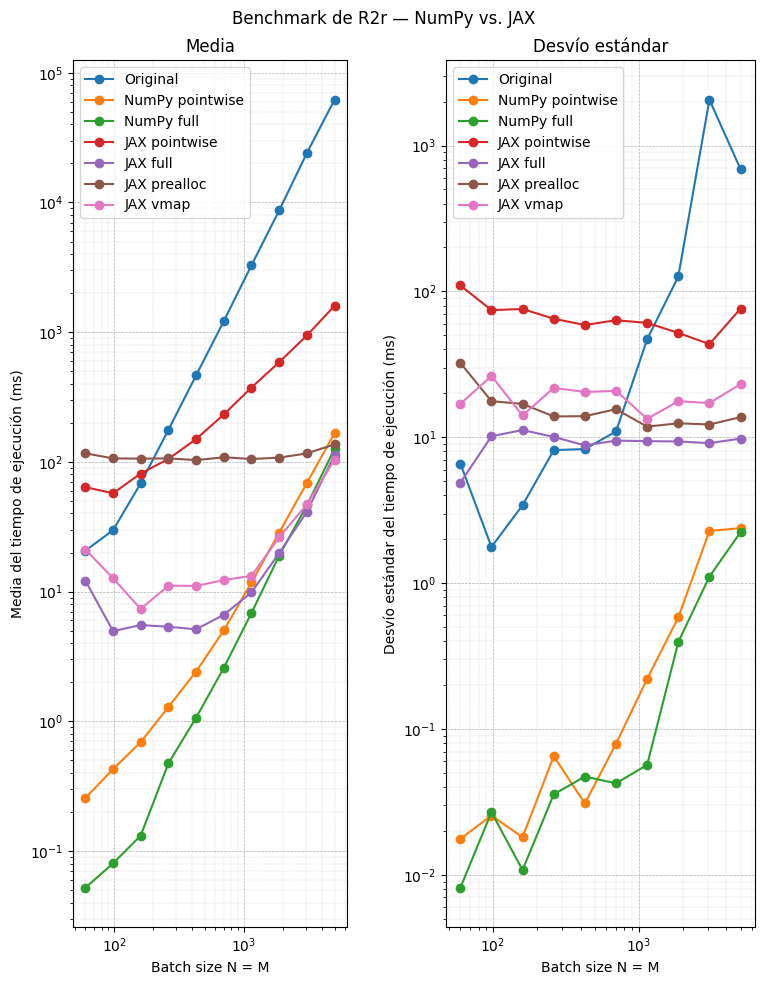

In [4]:
# Gráficos
fig, ax = plt.subplots(1, 2, figsize=(8,10))
#fig_var, ax_std = plt.subplots(figsize=(15,10))


for name, vals in tiempos_mean.items():
    ax[0].loglog(N_vals, vals, marker='o', label=name)
    ax[1].loglog(N_vals, tiempos_std[name], marker='o', label=name)

ax[0].grid(which='major', linestyle='--', linewidth=0.5)
ax[0].grid(which='minor', linestyle=':',  linewidth=0.3)
ax[0].minorticks_on()
ax[0].set_aspect('equal', 'box')

ax[1].grid(which='major', linestyle='--', linewidth=0.5)
ax[1].grid(which='minor', linestyle=':',  linewidth=0.3)
ax[1].minorticks_on()
ax[1].set_aspect('equal', 'box')

ax[0].set_xlabel('Batch size N = M')
ax[0].set_ylabel('Media del tiempo de ejecución (ms)')
ax[0].set_title('Media')
ax[0].legend()

ax[1].set_xlabel('Batch size N = M')
ax[1].set_ylabel('Desvío estándar del tiempo de ejecución (ms)')
ax[1].set_title('Desvío estándar')
ax[1].legend()

fig.suptitle(('Benchmark de R2r — NumPy vs. JAX'))
plt.tight_layout()
plt.show()

En la figura anterior se muestran comportamientos esperables. En primer lugar, se puede ver que el enfoque original es superado casi siempre, en algunos casos por dos órdenes de magnitud en la media. 

Por otro lado y siguiendo con la media, se puede ver que a los menores números de transformaciones evaluados, las implementaciones de *JAX* sufren el costo de la compilación, ya que en dicha región exhiben curvas con poca pendiente, pero alto tiempo de ejecución. 

Los mejores resultados en casi todo el rango se obtuvieron con la implementación `TernasMoviles2D_numpy.R2r_full`. Recién aproximadamente a $N=1100$ comienza a ser superada levemente, de forma mucho menor que lo que esta supera al resto de implementaciones en tamaños menores.

También se advierte que la prealocación con *JAX* es costosa y en el rango evaluado no se amortiza. Los mejores resultados de *JAX* se obtuvieron con `R2r_jax_full` y `R2r_jax_vmap`, pero en el rango $10^1$ a $10^3$ el mejor método de *NumPy* es superior y lo llega a ser en un orden de magnitud.

En cuanto al desvío estándar, los métodos de *NumPy* vectorizados cuentan con los menores desvíos estándar, que aumentan con el número de transformaciones. Con el método original también aumentan con el número de iteraciones, pero son sistemáticamente mayores. En las implementaciones de *JAX* y en el rango de $N$ evaluado el desvío estándar no muestra una marcada variación con $N$, probablemente también sea porque la compilación sigue dominando el costo temporal.

Por todo esto se decidió utilizar la clase `TernasMoviles2D\_numpy` y métodos vectorizados como el que se utilizó, que hace uso de la función `einsum(...)` de *NumPy* que aplica sumas, productos, trasposiciones de matrices y otras operaciones tensoriales lineales, al definir la operación utilizando notación de einstein.